In [4]:
import pandas as pd
import pybaseball
import pickle
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance

from sklearn.model_selection import cross_val_score


import matplotlib.pyplot as plt
import seaborn as sns

from pybaseball import statcast

In [2]:
# year = 2023

# data = statcast(start_dt= f"{year}-03-30",
#                 end_dt = f"{year}-09-30")

In [5]:
data = pd.read_csv("/Users/aidanbeilke/Desktop/Hawks Apps/Scouting App/CopyOfTM_2024_reg_szn (1).csv")

/var/folders/z9/0qsxxzxs1hb9r22xy18sfdbc0000gn/T/ipykernel_87340/4134882111.py:1: DtypeWarning: Columns (27,92,93,94) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("/Users/aidanbeilke/Desktop/Hawks Apps/Scouting App/CopyOfTM_2024_reg_szn (1).csv")


In [6]:
vars = data.columns.tolist()

vars

['PitchNo',
 'Date',
 'Time',
 'PAofInning',
 'PitchofPA',
 'Pitcher',
 'PitcherId',
 'PitcherThrows',
 'PitcherTeam',
 'Batter',
 'BatterId',
 'BatterSide',
 'BatterTeam',
 'PitcherSet',
 'Inning',
 'Top.Bottom',
 'Outs',
 'Balls',
 'Strikes',
 'TaggedPitchType',
 'AutoPitchType',
 'PitchCall',
 'KorBB',
 'TaggedHitType',
 'PlayResult',
 'OutsOnPlay',
 'RunsScored',
 'Notes',
 'RelSpeed',
 'VertRelAngle',
 'HorzRelAngle',
 'SpinRate',
 'SpinAxis',
 'Tilt',
 'RelHeight',
 'RelSide',
 'Extension',
 'VertBreak',
 'InducedVertBreak',
 'HorzBreak',
 'PlateLocHeight',
 'PlateLocSide',
 'ZoneSpeed',
 'VertApprAngle',
 'HorzApprAngle',
 'ZoneTime',
 'ExitSpeed',
 'Angle',
 'Direction',
 'HitSpinRate',
 'PositionAt110X',
 'PositionAt110Y',
 'PositionAt110Z',
 'Distance',
 'LastTrackedDistance',
 'Bearing',
 'HangTime',
 'pfxx',
 'pfxz',
 'x0',
 'y0',
 'z0',
 'vx0',
 'vy0',
 'vz0',
 'ax0',
 'ay0',
 'az0',
 'HomeTeam',
 'AwayTeam',
 'Stadium',
 'Level',
 'League',
 'GameID',
 'PitchUID',
 'Effec

In [7]:
model_vars = ['TaggedPitchType', 'RelSpeed', 'SpinRate', 'HorzBreak', 'InducedVertBreak', 'PitcherThrows']


df = data[model_vars]


In [8]:
def calculate_null_perc(df):
    null_pct = df.isnull().mean()
    return null_pct

calculate_null_perc(df)

TaggedPitchType     0.000000
RelSpeed            0.007112
SpinRate            0.007547
HorzBreak           0.012899
InducedVertBreak    0.012899
PitcherThrows       0.000000
dtype: float64

In [9]:
df = df.dropna()

df.head()

,TaggedPitchType,RelSpeed,SpinRate,HorzBreak,InducedVertBreak,PitcherThrows
0,Fastball,86.55415,1989.759006,-10.17658,17.15903,Left
1,Fastball,87.26088,2097.654143,-9.39705,17.51871,Left
2,Slider,78.18539,2284.087648,6.12819,-0.56587,Left
3,ChangeUp,78.84801,1499.346297,6.97162,1.78236,Left
4,Fastball,87.61871,2147.434557,-2.22547,20.00021,Left


In [15]:
df['PitcherThrows'] = df['PitcherThrows'].map({'Right': 0, 'Left': 1})

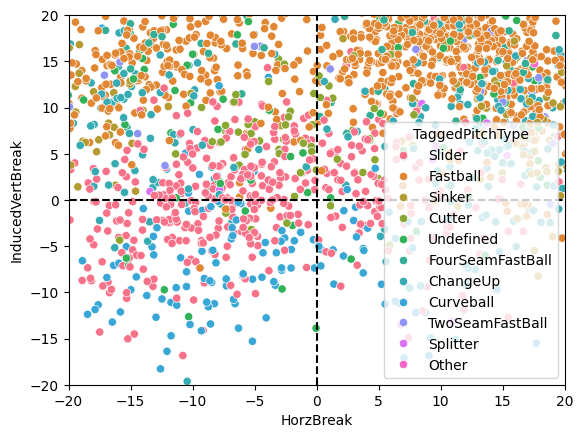

In [22]:
subset = df.sample(2000)

sns.scatterplot(data = subset,
                x = 'HorzBreak',
                y = 'InducedVertBreak',
                hue = 'TaggedPitchType')

plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.axvline(x = 0, linestyle = '--', color = 'black')
plt.axhline(y = 0, linestyle = '--', color = 'black')

plt.show()

In [20]:
df['TaggedPitchType'].unique()

array(['Fastball', 'Slider', 'ChangeUp', 'Curveball', 'Splitter',
       'Cutter', 'Sinker', 'FourSeamFastBall', 'TwoSeamFastBall',
       'Undefined', 'Other', 'Knuckleball', 'OneSeamFastBall', 'Changeup'],
      dtype=object)

In [11]:
pitch_types = ['Fastball', 'Slider', 'ChangeUp', 'Curveball', 'Splitter', 'Cutter', 'Sinker', 'FourSeamFastBall', 'TwoSeamFastBall', 'Changeup']
df = df[df['TaggedPitchType'].isin(pitch_types)]

def classify_pitch_type(pitch_type):
    if pitch_type in ['Fastball', 'FourSeamFastBall']:
        return 'Fastball'
    elif pitch_type in ['Sinker', 'TwoSeamFastBall']:
        return 'Sinker'
    elif pitch_type in ['ChangeUp', 'Changeup']:
        return 'ChangeUp'  
    else:
        return pitch_type

df['TaggedPitchType'] = df['TaggedPitchType'].apply(classify_pitch_type)

In [12]:
df['pitch_type_code'] = df['TaggedPitchType'].astype('category').cat.codes

df.loc[:, ['TaggedPitchType', 'pitch_type_code']].drop_duplicates().sort_values(by = 'pitch_type_code')

,TaggedPitchType,pitch_type_code
3,ChangeUp,0
152,Curveball,1
789,Cutter,2
0,Fastball,3
902,Sinker,4
2,Slider,5
445,Splitter,6


### Begin Pitch Type Classification

In [13]:
df = df.dropna()

In [14]:
X = df.drop(['pitch_type_code', 'TaggedPitchType'], axis=1)

y = df['pitch_type_code']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [16]:
X_train.shape, X_test.shape

((1121836, 5), (280460, 5))

In [17]:
y_train.shape, y_test.shape

((1121836,), (280460,))

In [18]:
knn = KNeighborsClassifier(n_neighbors=5)


# fit the model to the training set
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [19]:
y_pred = knn.predict(X_test)


In [20]:
def print_metrics_function(y_test, y_pred):
    print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
    confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    print("Confusion Matrix:")
    print(confmat)
    print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    print('F1-measure: %.3f' % f1_score(y_true=y_test, y_pred=y_pred, average='weighted'))

print_metrics_function(y_test, y_pred)

Accuracy: 0.78
Confusion Matrix:
[[ 23907    312    237   4059    334   2453    233]
 [   420  10684     72    102      4   7530     22]
 [   294     67   2665   1672     20   4205      4]
 [  4868    105   1294 124862   4957   1290     11]
 [  1394     22     58  11972   3972    213      4]
 [  2453   5225   2480   1198     69  53153     42]
 [   930     43     20     78      9    163    279]]
Precision: 0.766
Recall: 0.783
F1-measure: 0.771


### Hyperparameter Tune

In [21]:
neighbors = range(1, 21) 
metrics = ['euclidean', 'manhattan'] 
weights_options = ['uniform', 'distance'] 


In [22]:
best_accuracy = 0
best_params = {}

for metric in metrics:
    for weight in weights_options:
        for k in neighbors:
            # Initialize the KNN classifier with current parameters
            knn = KNeighborsClassifier(n_neighbors=k, metric=metric, weights=weight)
            
            # Train the classifier
            knn.fit(X_train, y_train)
            
            # Make predictions
            y_pred = knn.predict(X_test)
            
            # Evaluate the classifier
            accuracy = accuracy_score(y_test, y_pred)
            print(f"Metrics: {metric}, Weights: {weight}, Neighbors: {k}, Accuracy: {accuracy:.4f}")
            
            # Store parameters if they provide a better accuracy
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {'metric': metric, 'weight': weight, 'n_neighbors': k}

print("Best Accuracy:", best_accuracy)
print("Best Parameters:", best_params)


Metrics: euclidean, Weights: uniform, Neighbors: 1, Accuracy: 0.7303
Metrics: euclidean, Weights: uniform, Neighbors: 2, Accuracy: 0.7289
Metrics: euclidean, Weights: uniform, Neighbors: 3, Accuracy: 0.7651
Metrics: euclidean, Weights: uniform, Neighbors: 4, Accuracy: 0.7751
Metrics: euclidean, Weights: uniform, Neighbors: 5, Accuracy: 0.7827
Metrics: euclidean, Weights: uniform, Neighbors: 6, Accuracy: 0.7862
Metrics: euclidean, Weights: uniform, Neighbors: 7, Accuracy: 0.7898
Metrics: euclidean, Weights: uniform, Neighbors: 8, Accuracy: 0.7918
Metrics: euclidean, Weights: uniform, Neighbors: 9, Accuracy: 0.7933
Metrics: euclidean, Weights: uniform, Neighbors: 10, Accuracy: 0.7947
Metrics: euclidean, Weights: uniform, Neighbors: 11, Accuracy: 0.7955
Metrics: euclidean, Weights: uniform, Neighbors: 12, Accuracy: 0.7965
Metrics: euclidean, Weights: uniform, Neighbors: 13, Accuracy: 0.7970
Metrics: euclidean, Weights: uniform, Neighbors: 14, Accuracy: 0.7977
Metrics: euclidean, Weights: 

### Train Model with Best Params

In [23]:
knn_best = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'],
                                metric=best_params['metric'],
                                weights=best_params['weight'])


In [24]:
knn_best.fit(X_train, y_train)


KNeighborsClassifier(metric='manhattan', n_neighbors=20, weights='distance')

In [25]:
y_pred_best = knn_best.predict(X_test)

print_metrics_function(y_test, y_pred_best)

Accuracy: 0.80
Confusion Matrix:
[[ 24132    215    115   4178    259   2457    179]
 [   331  10462     28     83      0   7902     28]
 [   156     28   2192   1648     16   4883      4]
 [  3932     75    853 127923   3202   1398      4]
 [  1139     16     29  12598   3632    218      3]
 [  1849   3642   1199    932     33  56929     36]
 [   902     31     11     67      5    164    342]]
Precision: 0.785
Recall: 0.804
F1-measure: 0.787


## Feature Ranking

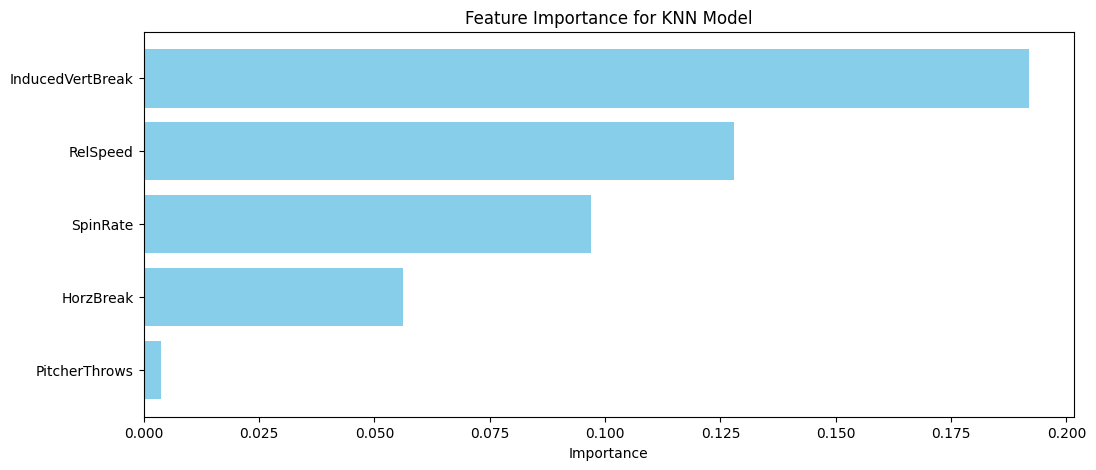

In [26]:
result = permutation_importance(knn_best, X_test, y_test, n_repeats=10, random_state=42)

features_names = X_train.columns

feature_importance_df = pd.DataFrame({'Feature': features_names,
                                      'Importance': result.importances_mean})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

fig, ax = plt.subplots(figsize=(12, 5))
ax.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
ax.set_xlabel('Importance')
ax.set_title("Feature Importance for KNN Model")

plt.show()


## Save Model

In [27]:
# Save the model to a file
with open('models/knn_best_model.pkl', 'wb') as file:
    pickle.dump(knn_best, file)
